<h1 style="text-align: center">Kaggle Titanic Dataset</h1>
<h3 style="text-align: center">Predicting passenger survival</h3>


In [364]:
import numpy as np
import matplotlib.pyplot as plt
import csv as csv
from IPython.display import clear_output
import math as math

ALPHA = 0.002
ESPILON = 0.00005
PREDICTION_THRESHOLD = 0.50
MAX_ITERATIONS = 100000
REGULARIZATION = 0.75
TRAIN_PERCENTAGE = 0.85

TRAIN_DATA_FILE = "train.csv"
TEST_DATA_FILE = "test.csv"
DATA_OUTPUT_NAME = "answers.csv"

UNKNOWN_AGE_INSERT = 30 # This is the assumption for the passenger if the age is unknown.

## Fetching and Organizing Data

#### Raw Passenger Data
Passenger Data is returned as a list of strings, in the order of the following:
*Passenger Id, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked*

#### Parsed Passenger Data
Passenger Data needs to be parsed and converted into numbers for the machine learning algorithms to take over. The following will be the parsing scheme. This will also be the order as well

1. **Passenger Id**: This will stay the same, nor will be converted into an int.
2. **Survived**: 0 for died, 1 for survived
3. **Pclass**: 1 for upper class, 2 for middle class, 3 for lower class
4. **Sex**: 0 for Male, 1 for Female
5. **Age**: Float from the string, if it is an empty string then going to default to age of 30 (arbitrary).
6. **SibSp**: Sibling/Spouse on board, staying the same.
7. **Parch**: # of Parent/Children on board, staying the same.
8. **Fare**: Convert to a float

In [365]:
def FetchPassengerData(fileName: str) -> list:
    """Gets the information and then returns a list of the passengers in the format shown below (as strings)

    Args:
        fileName (str): The csv file to open

    Returns:
        list: PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked 
    """
    result = []
    with open(fileName, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            result.append(row)
    return result

def ParseSurvived(survived: str) -> int:
    try:
        return int(float(survived))
    except Exception as ex:
        print(str(ex))
        return 0


def ParseAge(age: str) -> int:
    try:
        isAdult = int(age) >= 18
        if isAdult:
            Adult = -1
        else:
            Adult = 1

        return float(age) / 100, Adult
    except ValueError:
        return UNKNOWN_AGE_INSERT / 100, 0

def ParseFare(fare, pclass):
    try:
        if fare == '':
            if pclass == 1:
                return 70 / 100
            elif pclass == 2:
                return 25 / 100
            else:
                return 7.25 / 100
        else:
            return float(fare)
    except ValueError:
        print("Parseing fare went wrong.")
        return 7.25 / 100
    except Exception as ex:
        print(f"ParseFare error: {ex}")
        return 7.25 / 100

def ParseCabin(cabin):
    for a in cabin:
        if a == 'A':
            return 6
        elif a == 'B':
            return 5
        elif a == 'C':
            return 4
        elif a == 'D':
            return 3
        elif a == 'E':
            return 2
        elif a == 'F':
            return 1
        
    return 0

def ParseEmbarked(embarked):
    if embarked == 'C':
        return 1
    elif embarked == 'Q':
        return 2
    elif embarked == 'S':
        return 3
    else:
        return 0

def ParsePassengerData(passenger: list) -> list:
    """Takes passenger data and converts all the types to be usable for the machine learning. See the paragraph above for the information.
     

    Args:
        passenger (list): PassengerId, Survived (optional), Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked

    Returns:
        list: PassengerId, Survived, Pclass, Sex, Age, SibSp, Parch, Fare
    """
    try:
        # Passenger surviving wasn't added. Add a '0' for survivied (mirroring test data)
        if len(passenger) < 12:
            passenger.insert(1, '0')
        
        if len(passenger) < 12:
            print("List is less than 12 elements still.")
            print(f"Passenger: {passenger}")
            raise Exception(ValueError)
        
        PassengerId = float(passenger[0])
        Survived = float(ParseSurvived(passenger[1]))
        Pclass = float(passenger[2])
        #  Name is irrelevant (passenger[3])
        Sex = float(passenger[4] == 'female')
        Age, Adult = ParseAge(passenger[5])
        SibSp = float(passenger[6])
        Parch = float(passenger[7])
        # Ticket is irrelevant (passenger[8])
        Fare = ParseFare(passenger[9], Pclass)
        # Cabin will be relevant -- going to eventually make up a scheme and numbering system based general cabin location.
        Cabin = ParseCabin(passenger[10])
        # I doubt embarked will matter, might be worth adding later.
        Embarked = ParseEmbarked(passenger[11])
    except ValueError:
        print("Value Error")
        print(f"Passenger: {passenger}")
        raise Exception(ValueError)

    return np.array([PassengerId, Survived, Sex,
            Pclass * Pclass, Pclass * Pclass * Pclass, 
            Cabin * Cabin, Cabin * Cabin * Cabin,
            (SibSp + Parch) * Age,
            Pclass,   
            Age, 
            SibSp,
            Parch, 
            Cabin,
            Adult
            ])


In [366]:
Data = [ParsePassengerData(passenger=passenger) for passenger in FetchPassengerData(TRAIN_DATA_FILE)[1:]]
Males = 0
Females = 0
for passenger in Data:
    if passenger[2] == 0:
        Males += 1
    else:
        Females += 1

print(f"Males: {Males}\nFemales: {Females}")

Males: 577
Females: 314


## Training Functions

In [367]:
def sigmoid(z):
    try:
        return 1 / (1 + math.exp(-1 * z))
    except Exception as ex:
        print(f"ERROR -- Sigmoid -- {ex}")
        return 0

def CalcSurvivalPercentage(x: np.array, w: np.array, b: float) -> bool:
    return sigmoid(np.dot(x, w) + b)

def CalcSurvived(x: np.array, w: np.array, b: float) -> bool:
    return (CalcSurvivalPercentage(x, w, b)) > PREDICTION_THRESHOLD

def PassengerCostFunction(passenger: np.array, w: np.array, b: float) -> float:
    y = passenger[1]
    x_hat = np.array(passenger[3:])

    if y == 1:
        return -1 * y * math.log(sigmoid(np.dot(x_hat, w) + b))
    else:
        return -1 * (1 - y) * math.log(1 - sigmoid(np.dot(x_hat, w)))

def CalcTotalCost(passengers: list, w: np.array, b: float) -> float:
    sum = 0
    m = len(passengers)

    for passenger in passengers:
        sum += PassengerCostFunction(passenger, w, b)
    
    return sum / m

def Calc_dj_dw(passenger_list: list, w_hat: np.array, b: float) -> np.array:
    m = len(passenger_list)
    num_attributes = len(passenger_list[0][3:])
    results = []

    for i in range(num_attributes):
        sum = 0
        for passenger in passenger_list:
            y = passenger[1]
            x = np.array(passenger[3:])
            sum += (CalcSurvivalPercentage(x, w_hat, b) - y) * passenger[3 + i]
        results.append((sum / m) + (REGULARIZATION * w_hat[i] / m))
    
    return np.array(results)

def Calc_dj_db(passenger_list: list, w_hat: np.array, b: float) -> float:
    m = len(passenger_list)
    sum = 0
    for passenger in passenger_list:
        y = passenger[1]
        x = np.array(passenger[3:])
        sum += (CalcSurvivalPercentage(x, w_hat, b) - y)
    
    return sum / m

def Train_Iteration(passenger_list: list, w_hat: np.array, b: float):
    dj_dws = Calc_dj_dw(passenger_list, w_hat, b)
    new_ws = []

    if len(dj_dws) != len(w_hat):
        raise Exception("Number of dj_dws not the same as inputed w_hat")
    
    for i in range(len(w_hat)):
        temp_w = w_hat[i] - (ALPHA * (dj_dws[i]))
        new_ws.append(temp_w)

    new_b = b - (ALPHA * Calc_dj_db(passenger_list, w_hat, b))
    return np.array(new_ws), new_b

def CalcAccuracy(data: list, w_hat: np.array, b: float) -> float:
    Correct = 0

    for passenger in data:
        if passenger[1] == CalcSurvived(passenger[3:], w_hat, b):
            Correct += 1

    return Correct / len(data)

def FindBestCutoff(data: list, w_hat: np.array, b: float):
    best_cutoff = 0
    best_accuracy = 0

    for i in range(20):
        Test_Cutoff = 0.05 * i
        correct = 0

        for passenger in data:
            survived = passenger[1]
            attributes = np.array(passenger[3:])
            ChanceSurvival = CalcSurvivalPercentage(attributes, w_hat, b)
            prediction = ChanceSurvival > Test_Cutoff
            if survived == prediction:
                correct += 1
        accuracy = correct / len(data)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cutoff = Test_Cutoff
        
    return best_cutoff, best_accuracy



def TrainData(gender, UseGender = True, RunFullTest = True):
    RawData = FetchPassengerData(TRAIN_DATA_FILE)
    AllData = [np.array(ParsePassengerData(passenger)) for passenger in RawData[1:]]
    Data = []

    for passenger in AllData:
        if UseGender:
            if int(passenger[2]) == int(gender):
                Data.append(passenger)
        else:
            Data.append(passenger)
    
    NumDataToTrain = int(0.9 * len(Data))
    Data_Train = Data[:NumDataToTrain]
    Data_Test = Data[NumDataToTrain:]

    num_attributes = len(Data[0][3:])
    w_hat = np.array([0 for i in range(num_attributes)])
    b = 0

    hist_cost = []
    hist_test = []
    previous_cost_difference = 2000
    previous_cost = 2000
    cost = 0
    iteration = 0
    best_accuracy = 0

    if not RunFullTest:
        iteration = MAX_ITERATIONS - 100

    while (iteration < MAX_ITERATIONS) and ((previous_cost_difference > ESPILON) or (iteration < 100)):
        cost = CalcTotalCost(Data_Train, w_hat, b)
        accuracy = CalcAccuracy(Data_Test, w_hat, b)

        hist_cost.append(cost)
        hist_test.append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy

        if iteration % 100 == 0:
            previous_cost_difference = previous_cost - cost
            previous_cost = cost

            AccuracyView = "{:.1f}%".format(accuracy * 100)
            MaxAccuracyView = "{:.1f}%".format(best_accuracy * 100)
            clear_output(wait=True)
            print(f"\nIteration {iteration}: \n\tCost ({cost}) \n\tAccuracy: {AccuracyView} \n\tBest Accuracy: {MaxAccuracyView} \n\tW_Hat: {w_hat}\n\tB: {b}")

        w_hat, b = Train_Iteration(Data_Train, w_hat, b)
        iteration += 1
        recommended_cutoff, recommended_cutoff_accuracy = FindBestCutoff(Data_Test, w_hat, b)
    
    print(f"Recommended Cutoff: {recommended_cutoff}")
    print(f"Cutoff Accuracy: {recommended_cutoff_accuracy}")
    return w_hat, b, hist_cost, hist_test, recommended_cutoff
    


## Training

In [368]:
W_HAT, B, HIST_COST, HIST_TEST, RECOMMENDED_CUTOFF = TrainData(gender=False, UseGender=False, RunFullTest=False) # Combined


Iteration 99900: 
	Cost (0.6931471805599425) 
	Accuracy: 62.2% 
	Best Accuracy: 62.2% 
	W_Hat: [0 0 0 0 0 0 0 0 0 0 0]
	B: 0
Recommended Cutoff: 0.45
Cutoff Accuracy: 0.7444444444444445


In [369]:
mW_HAT, mB, mHIST_COST, mHIST_TEST, mRECOMMENDED_CUTOFF = TrainData(gender=False) # Male


Iteration 1900: 
	Cost (0.47420801007551777) 
	Accuracy: 81.0% 
	Best Accuracy: 81.0% 
	W_Hat: [-0.15081046  0.00049134 -0.00765982  0.00264353 -0.03378768 -0.13917706
 -0.06465936 -0.02708581  0.03887624  0.02045879  0.15924872]
	B: -0.10459951680053087
Recommended Cutoff: 0.5
Cutoff Accuracy: 0.8103448275862069


In [370]:
fW_HAT, fB, fHIST_COST, fHIST_TEST, fRECOMMENDED_CUTOFF = TrainData(gender=True) # Female


Iteration 91800: 
	Cost (0.25927641182208555) 
	Accuracy: 78.1% 
	Best Accuracy: 81.2% 
	W_Hat: [ 0.74675777 -0.39686561 -0.1998961   0.04180838  0.29781713  1.03778262
  0.15901289 -0.40268462 -0.38843937  0.29126135  0.48589197]
	B: 1.522315943901006
Recommended Cutoff: 0.6000000000000001
Cutoff Accuracy: 0.875


## Results

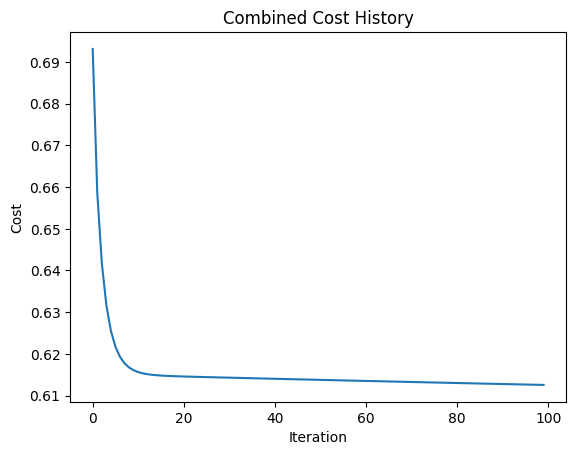

In [371]:
plt.plot(HIST_COST)
plt.title("Combined Cost History")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

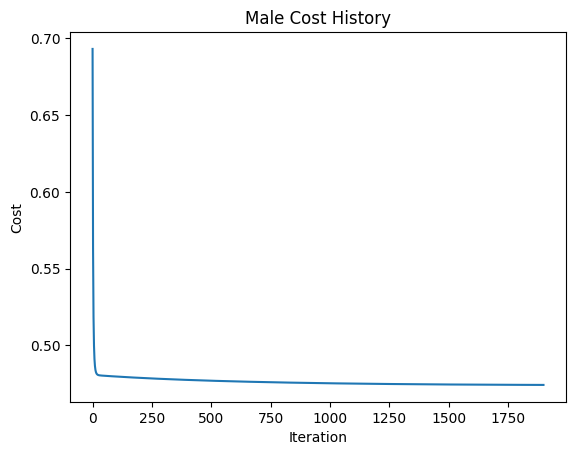

In [372]:
plt.plot(mHIST_COST)
plt.title("Male Cost History")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

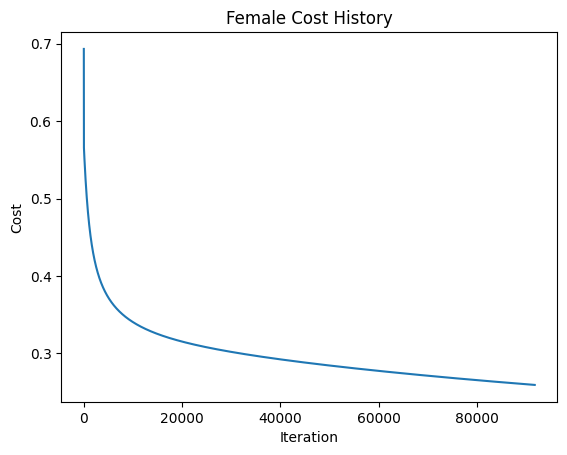

In [373]:
plt.plot(fHIST_COST)
plt.title("Female Cost History")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

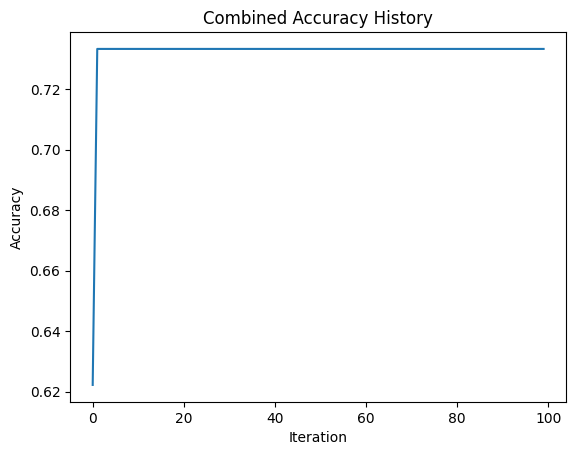

In [374]:
plt.plot(HIST_TEST)
plt.title("Combined Accuracy History")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

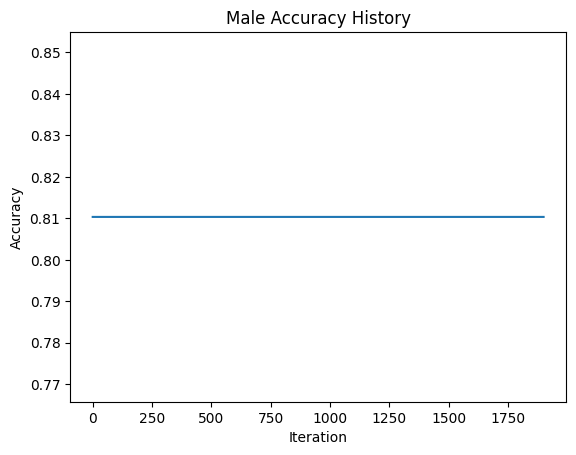

In [375]:
plt.plot(mHIST_TEST)
plt.title("Male Accuracy History")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

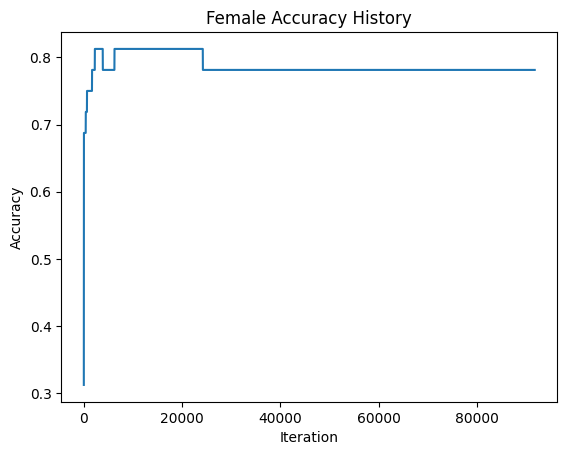

In [376]:
plt.plot(fHIST_TEST)
plt.title("Female Accuracy History")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

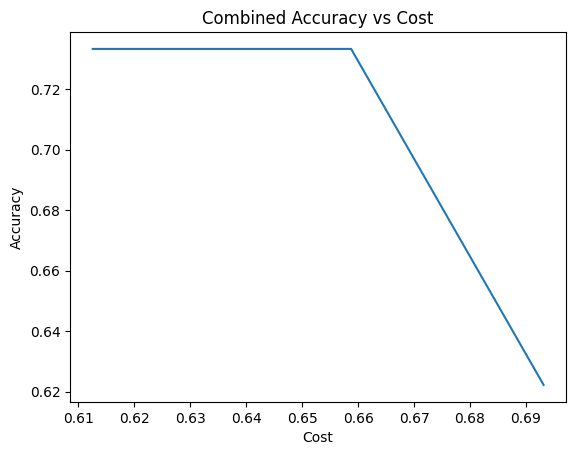

In [377]:
plt.plot(HIST_COST, HIST_TEST)
plt.title("Combined Accuracy vs Cost")
plt.xlabel("Cost")
plt.ylabel("Accuracy")
plt.show()

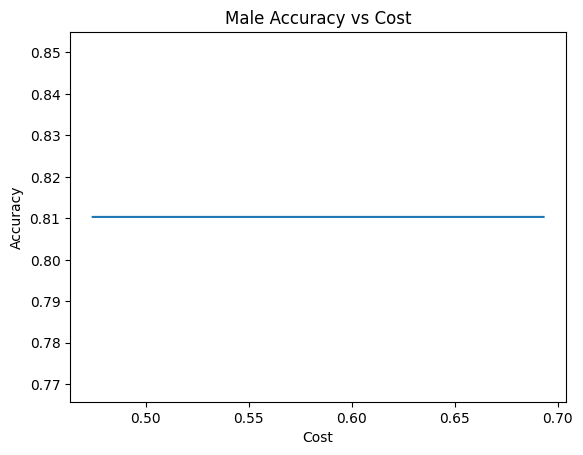

In [378]:
plt.plot(mHIST_COST, mHIST_TEST)
plt.title("Male Accuracy vs Cost")
plt.xlabel("Cost")
plt.ylabel("Accuracy")
plt.show()

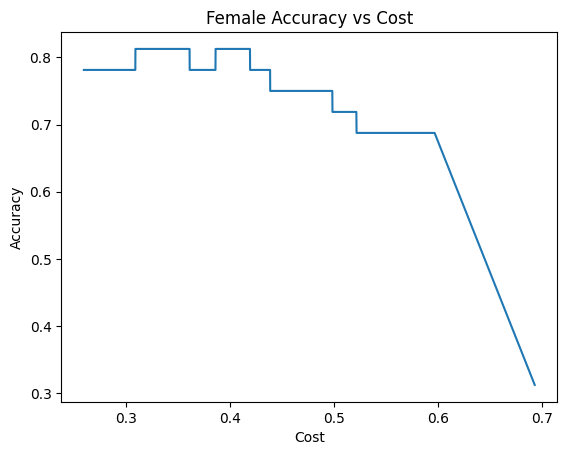

In [379]:
plt.plot(fHIST_COST, fHIST_TEST)
plt.title("Female Accuracy vs Cost")
plt.xlabel("Cost")
plt.ylabel("Accuracy")
plt.show()

## Predictions

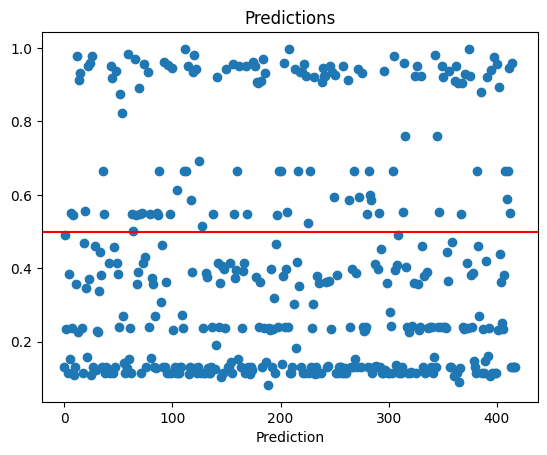

In [380]:
# Testing the formula
def MakePredictions(mCutoff, fCutoff):
    TestRawData = FetchPassengerData(TEST_DATA_FILE) # Fetchin the raw data from the CSV file
    TestData = [np.array(ParsePassengerData(passenger)) for passenger in TestRawData[1:]] # The data parsed to use to train
    PredictionList = []

    for passenger in TestData:
        if passenger[2] == 0:
            Prediction = CalcSurvivalPercentage(passenger[3:], mW_HAT, mB)
            Guess = Prediction > PREDICTION_THRESHOLD
        else:
            Prediction = CalcSurvivalPercentage(passenger[3:], fW_HAT, fB)
            Guess = Prediction > PREDICTION_THRESHOLD
        
        PredictionList.append((passenger[0], Prediction, Guess))
    
    return PredictionList

def WriteAnswersCSVFile(fname, PredictionList):

    with open(fname, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['PassengerId', 'Survived'])

        for pred in PredictionList:
            result = [str(int(pred[0]))]
            if pred[2]:
                result.append('1')
            else:
                result.append('0')
            
            writer.writerow(result)

Predictions = MakePredictions(mRECOMMENDED_CUTOFF, fRECOMMENDED_CUTOFF)

WriteAnswersCSVFile('submission.csv', Predictions)

predictionsOnly = [pred[1] for pred in Predictions]
plt.scatter([i for i in range(len(predictionsOnly))], predictionsOnly)
plt.axhline(y=PREDICTION_THRESHOLD, color='r', linestyle='-')
plt.title("Predictions")
plt.xlabel("Prediction")
plt.show()